# **COMS4995AML Project: Image Captioning**

**Group 25**

Building a simple image captioning model using pre-trained VGG16 and LSTM

In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM,\
 Dense, Concatenate, Dropout, Flatten, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# **1. Preprocessing Data**

In [ ]:
from google.colab import drive

drive.mount("./drive")

Mounted at ./drive


In [ ]:
%cd drive/MyDrive/COMS4995AML_Project

/content/drive/MyDrive/COMS4995AML_Project


Preprocessing the data

In [ ]:
# Reading the filtered data
flickr_df = pd.read_excel("./captions.xlsx")

# Removing all punctuations
regex = r"[^\s\w]"
flickr_df["comment"] = flickr_df["comment"].str.replace(regex, "", regex=True)

# Converting all words to lower case
def lower_case(text):
  return text.lower()
flickr_df["comment"] = flickr_df["comment"].apply(lower_case)

flickr_df.head()

,image_name,comment
0,1001773457.jpg,a black dog and a white dog with brown spots ...
1,1001773457.jpg,a black dog and a tricolored dog playing with...
2,1001773457.jpg,a black dog and a spotted dog are fighting
3,1003163366.jpg,a man sleeping on a bench outside with a whit...
4,1003163366.jpg,a man lays on the bench to which a white dog ...


In [ ]:
print("Number of images in the dataset: ",
      len(set(list(flickr_df["image_name"]))))
print("Number of captions in the dataset: ",
      len(list(flickr_df["comment"])))

Number of images in the dataset:  2494
Number of captions in the dataset:  9403


Adding a category column for each caption. Categories include "dog", "cat", "horse", and "cow".

In [ ]:
# Categories
categories = [["dog", "puppy"], ["cat", "kitten"], ["horse"], ["cow"]]

# Using NLTK to parse the comment column and detect
# the presence of key words for our categories
def classify_animal(text):
  if isinstance(text, str):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    for word, tag in tagged_words:
      if tag in ["NN", "NNS"]:
        for c in categories:
          if word.lower() in c:
            return c[0]
    return "other"

# flickr_df_copy will have a "category" column added
flickr_df_copy = flickr_df.copy(deep = True)
flickr_df_copy["category"] = flickr_df["comment"].apply(classify_animal)
flickr_df_copy.head()

# **2. Splitting train_df, val_df, test_df**

We have an imbalanced dataset where there are a lot of images in the "dog" category and a few images in the other categories. Hence, we used the stratify strategy to preserve the proportions from the dataset. While the category column in the table is never used directly in training the captioning program, it nonetheless is essential for our stratified splitting at this stage.

Around 53.3% of the data are for training, 26.7% of the data are for validation, and 20% of the data are for testing.

In [ ]:
dev_df, test_df = train_test_split(flickr_df_copy, test_size = 0.2,
                                   stratify = flickr_df_copy["category"],
                                   shuffle = True)
train_df, val_df = train_test_split(dev_df, test_size = 0.333,
                                    stratify = dev_df["category"],
                                    shuffle = True)

We saved train_df, val_df, and test_df so that we don't have to split the data every time we run the notebook.

In [ ]:
train_df.to_csv("train_df.csv", index = False)
val_df.to_csv("val_df.csv", index = False)
test_df.to_csv("test_df.csv", index = False)

In [ ]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((5017, 3), (2505, 3), (1881, 3))

## **3. Computer Vision: use VGG-16 model for image feature extraction**



In [ ]:
# Define a VGG-16 model for feature extraction
# load pre-trained weights from ImageNet
vgg16_model = VGG16(weights="imagenet")

# We omit the very last fully connected layer in VGG16
# since our categories aren't the same as ImageNet ones
vgg16_model = Model(inputs=vgg16_model.inputs,
                    outputs=vgg16_model.layers[-2].output)

# VGG16 is frozen since its weights don't require any
# further training for our program
for layer in vgg16_model.layers:
  layer.trainable = False

In [ ]:
def predict_image_feature(image):
  return vgg16_model.predict(image)

# This function opens an image file and extracts its feature for VGG16
def extract_features(filename):
  try:
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Prediction using the VGG-16 model
    feature = predict_image_feature(image)
    return feature

  # In case a training image is corrupted and can't be opened
  except:
    print("Failed to Open: ", filename)
    return None

In [ ]:
DATA_DIR = "./Images"
feature_dict = {}

Extracting image embeddings for train_df

In [ ]:
# Extracting image embeddings from train_df image names. The dictionary
# feature_dict stores processed images since some of the images correspond
# to multiple comments. This speeds up the processing

image_embeddings = []
for img_path in train_df["image_name"]:
  if img_path not in feature_dict:
    img = extract_features(DATA_DIR + "/" + img_path)
    if img is None:
      pass
    feature_dict[img_path] = img
  else:
    img = feature_dict[img_path]
  image_embeddings.append(img)

train_image_embeddings = np.array(image_embeddings)

In [ ]:
# Saving the NumPy array for train image embeddings
np.save("train_image_embeddings", train_image_embeddings)

In [ ]:
train_image_embeddings = np.load("train_image_embeddings.npy", allow_pickle=True)

Extracting image embeddings for val_df

In [ ]:
# Extracting image embeddings for validation images in val_df
image_embeddings = []
for img_path in val_df["image_name"]:
  if img_path not in feature_dict:
    img = extract_features(DATA_DIR + "/" + img_path)
    if img is None:
      pass
    feature_dict[img_path] = img
  else:
    img = feature_dict[img_path]
  image_embeddings.append(img)

val_image_embeddings = np.array(image_embeddings)

In [ ]:
np.save("val_image_embeddings", val_image_embeddings)

In [ ]:
val_image_embeddings = np.load("val_image_embeddings.npy", allow_pickle=True)

Extracting image embeddings for test_df

In [ ]:
# Extracting image embeddings for test_df
image_embeddings = []
for img_path in test_df["image_name"]:
  if img_path not in feature_dict:
    img = extract_features(DATA_DIR + "/" + img_path)
    if img is None:
      img = np.zeros((1, 4096))
    feature_dict[img_path] = img
  else:
    img = feature_dict[img_path]
  image_embeddings.append(img)

test_image_embeddings = np.array(image_embeddings)

In [ ]:
np.save("test_image_embeddings", test_image_embeddings)

In [ ]:
test_image_embeddings = np.load("test_image_embeddings.npy", allow_pickle=True)

In [ ]:
test_image_embeddings.shape, train_image_embeddings.shape, val_image_embeddings.shape

((1881, 1, 4096), (5017, 1, 4096), (2505, 1, 4096))

# **4. Define the ImageCaptionGenerator Class**

Since the input data and labels for our model are multimodal, a customized generator is required for training the model. In the generator defined below, we pass batches of image_embeddings, text_embedding, next_token_embedding. This way, the model can learn to use image embeddings and partial text to generate the next caption.

In [ ]:
class ImageCaptionGenerator(tf.keras.utils.Sequence):
  def __init__(self, img_embeddings, captions, tokenizer,
               max_length, batch_size=32):
    self.img_embeddings = img_embeddings
    self.captions = captions
    self.tokenizer = tokenizer # the tokenizer instance used for encoding
    self.max_length = max_length # maximum length of generated captions
    self.batch_size = batch_size

    def __len__(self): # A required function for the interface
      return len(self.captions) // self.batch_size

    # Another required function of the interface which
    # returns one batch of input to the model
    def __getitem__(self, idx):
      start = idx * self.batch_size
      end = (idx + 1) * self.batch_size
      batch_images = self.img_embeddings[start:end] # batch of images
      batch_captions = self.captions[start:end] # batch of captions

      X_images, X_seq, y = [], [], []
      for img_emb, cap in zip(batch_images, batch_captions):

        # captions are encoded by the tokenizer
        seq = self.tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):

          # input for text is the encoding of the partial sequence while the
          # label for text is the one-hot-encoding of the next token
          in_seq, out_seq = seq[:i], seq[i]

          # padding is required to keep sizes consistent
          in_seq = pad_sequences([in_seq],
                                 maxlen=self.max_length, padding='post')[0]
          out_seq = tf.keras.utils.to_categorical([out_seq],
                                                  num_classes=vocab_size)[0]
          X_images.append(img_emb)
          X_seq.append(in_seq)
          y.append(out_seq)
      return [np.array(X_images), np.array(X_seq)], np.array(y)

In [ ]:
train_captions = train_df["comment"]
val_captions = val_df["comment"]
test_captions = test_df["comment"]

In [ ]:
# Tokenizer instance for text encoding
tokenizer = Tokenizer()

# Instance is trained on the training captions
tokenizer.fit_on_texts(train_captions)

# word_index provides dictionary for encodings so
# so it can be used to define size of our vocabulary
vocab_size = len(tokenizer.word_index) + 1

Using the tokenizer defined above, we convert our lists of captions into encoded lists of captions. Note that the Tokenizer is trained on the training captions and it is then used below to convert sequences of texts into sequences of encodings for the model

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_captions)
val_sequences = tokenizer.texts_to_sequences(val_captions)
test_sequences = tokenizer.texts_to_sequences(test_captions)

In [ ]:
batch_size = 64
max_length = 20 # chosen from observation

Finally, a generator can be constructed from each of training, validation, and testing data. These generators will be used during the model training and evaluation

In [ ]:
# Generators can now be passed to model.fit()
train_generator = ImageCaptionGenerator(
    np.squeeze(train_image_embeddings, axis=1),
    train_captions, tokenizer, max_length, batch_size)

val_generator = ImageCaptionGenerator(
    np.squeeze(val_image_embeddings, axis=1),
    val_captions, tokenizer, max_length, batch_size)

test_generator = ImageCaptionGenerator(
    np.squeeze(test_image_embeddings, axis=1),
    test_captions, tokenizer, max_length, batch_size)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size #our vocabulary size

2602

# **5. The caption generation model**

In [ ]:
embedding_dim = 300 # Embedding dimension for the text data
img_feature_dim = 4096  # Feature dimensions from VGG16
units = 512 # Number of LSTM units

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.25)(inputs1) # Dropout to prevent overfitting
fe2 = Dense(units, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.25)(se1) # Dropout to prevent overfitting
se3 = LSTM(units, recurrent_dropout=0.35)(se2)

# Combining text and image input for classification
# This allows the fully connected layers to take both image and
# text into account when generating the next token in the caption
decoder1 = Add()([fe2, se3])
decoder2 = Dense(units, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 20, 300)              780600    ['input_4[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_3[0][0]']             
                                                                                              

## **6. Training**

Finally, the caption generation model can be trained. The optimal model weights will be stored in "model_weights.h5". Here, the optimal model weights will be defined as the model weights that achieved the lowest loss on the validation data. These weights will be restored once the training is completed. Moreover, the model will monitor validation loss and if there are no improvements in the validation loss for 3 epochs, early stopping is invoked to prevent overfitting to the training data.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'model_weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    verbose=1)

# Model is trained for a maximum of 50 epochs
model_hist = model.fit(train_generator, validation_data = val_generator,
                       epochs=50, batch_size=64,
                       callbacks=[early_stopping, checkpoint])

Epoch 1/50
5013/5017 [============================>.] - ETA: 0s - loss: 4.3631
Epoch 1: val_loss improved from inf to 3.79195, saving model to model_weights.h5
5017/5017 [==============================] - 88s 16ms/step - loss: 4.3630 - val_loss: 3.7920
Epoch 2/50
5014/5017 [============================>.] - ETA: 0s - loss: 3.6609
Epoch 2: val_loss improved from 3.79195 to 3.54319, saving model to model_weights.h5
5017/5017 [==============================] - 74s 15ms/step - loss: 3.6612 - val_loss: 3.5432
Epoch 3/50
5017/5017 [==============================] - ETA: 0s - loss: 3.3488
Epoch 3: val_loss improved from 3.54319 to 3.43446, saving model to model_weights.h5
5017/5017 [==============================] - 75s 15ms/step - loss: 3.3488 - val_loss: 3.4345
Epoch 4/50
5017/5017 [==============================] - ETA: 0s - loss: 3.1657
Epoch 4: val_loss did not improve from 3.43446
5017/5017 [==============================] - 72s 14ms/step - loss: 3.1657 - val_loss: 3.5007
Epoch 5/50
501

# **7. Visualizing loss**

Visualizing the validation and train loss obtained from running our model for the above epochs:

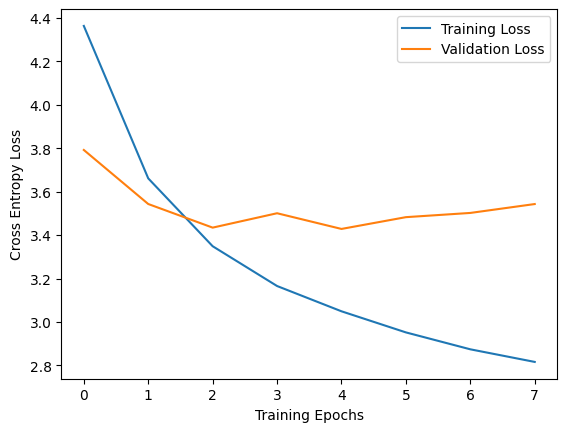

In [ ]:
from matplotlib import pyplot as plt

plt.plot(model_hist.history['loss'], label='Training Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Training Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title('Training and Validation loss per epoch')
plt.show()

From the above plot, we observe a clear decrease in the training loss, and a decrease and then slight increase towards the end for the validation loss. As reflected in the early stopping, the model gradually overfits to the training data, and is prevented from doing that by our callbacks.

# **8. Results: Generating captions**

Since the optimal model weights were saved, they can now be loaded and used immediately for evaluation

In [ ]:
%cd 'Code Submission'

/content/drive/MyDrive/COMS4995AML_Project/Code Submission


In [ ]:
model.load_weights('model_weights.h5')

In [ ]:
def generate_caption(model, tokenizer, photo_feature, max_length):
  # This is a special token to indicate start of the generated caption
  in_text = 'startseq'

  # Expanding dimension formats input image into a batch of 1
  # which is required for model since it was trained on batches
  photo_feature = np.expand_dims(photo_feature, axis=0)

  for i in range(max_length):
    # Encoding the sequence of tokens
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # Padding until max_length is reached
    sequence = pad_sequences([sequence], maxlen=max_length)

    # Next token is generated by the model prediction
    yhat = model.predict([photo_feature, sequence], verbose=0)
    # The most likely token is chosen
    yhat = np.argmax(yhat, axis=-1)

    word_index = int(yhat[0])
    # The predicted token is mapped back to a word based on the tokenizer
    word = tokenizer.index_word.get(word_index, '')

    # Generation stops when the special token for end of sequence
    # or the empty string is seen
    if word == '' or word == 'endseq':
      break

    # Predicted token is appended to our caption
    in_text += ' ' + word

  #Removing the startseq and endseq
  final_caption = in_text.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption

Below, a few example captions are provided alongside with the reference captions and images from the dataset. The BLEU metric is used to provide a quantitative measure of the quality of the caption

Example 1:

Generated Caption: horse jumping rider in a rodeo rodeo rodeo a rodeo a rodeo is riding a horse in a rodeo
Actual Caption:  ['a bucking brown horse next to a falling cowboy'] 

Bleu Score:  0.16840394156133062 



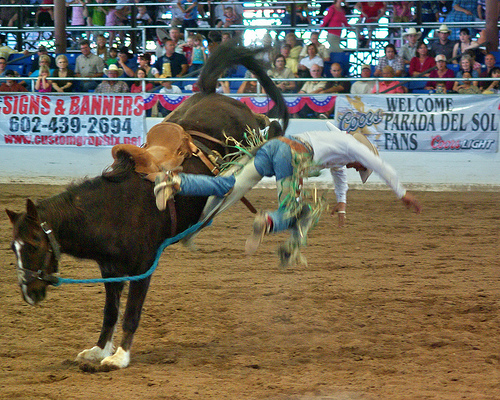

In [ ]:
from PIL import Image

# Since image embeddings have already been calculated, they can be used
# directly for prediction without need for more pre-processing
photo_feature = np.squeeze(test_image_embeddings, axis = 1)[300]
caption = generate_caption(model, tokenizer, photo_feature, max_length)
actual_captions = \
list(test_df[test_df["image_name"] == test_df["image_name"][300]]["comment"])
print("Generated Caption:", caption)
print("Actual Caption: ", actual_captions, "\n")
print("Bleu Score: ", sentence_bleu(actual_captions, caption), "\n")
Image.open("../Images/" + test_df["image_name"][300])

Example 2:

Generated Caption: brown dog running through grass with a orange ball in its mouth is running through the grass with a
Actual Caption:  ['the little brown dog runs past another dog on the grass'] 

Bleu Score:  0.2821075432377299 



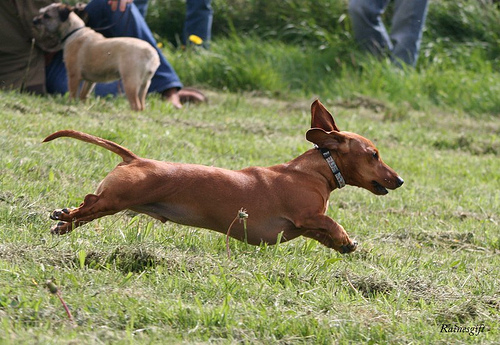

In [ ]:
photo_feature = np.squeeze(test_image_embeddings, axis = 1)[2]
caption = generate_caption(model, tokenizer, photo_feature, max_length)
actual_captions = \
list(test_df[test_df["image_name"] == test_df["image_name"][2]]["comment"])
print("Generated Caption:", caption)
print("Actual Caption: ", actual_captions, "\n")
print("Bleu Score: ", sentence_bleu(actual_captions, caption), "\n")
Image.open("../Images/" + test_df["image_name"][2])

Example 3:

Generated Caption: dog running through the water with a stick in its mouth is running through the water with a stick
Actual Captions: 
   a spotted black and white dog splashes in the water
   a black and white dog is running though water whilst bearing its teeth
   a black and white dog is running and splashing in water
Average Bleu Score:  0.28953074057302325 

Highest Bleu Score:  0.38403413539641235 



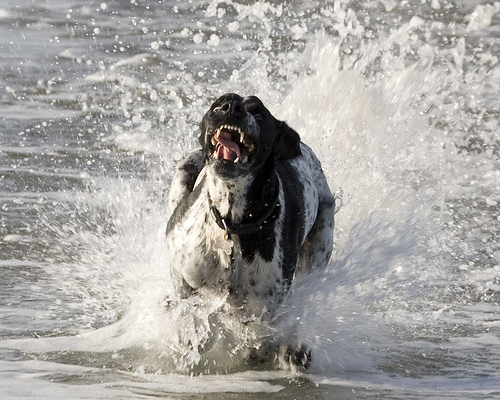

In [ ]:
photo_feature = np.squeeze(test_image_embeddings, axis = 1)[1876]
caption = generate_caption(model, tokenizer, photo_feature, max_length)
actual_captions = \
list(test_df[test_df["image_name"] == test_df["image_name"][1876]]["comment"])
print("Generated Caption:", caption)
print("Actual Captions: ")
for cap in actual_captions:
  print("  ", cap)
bleu_scores = []
for i in range(len(actual_captions)):
  bleu_scores.append(sentence_bleu([actual_captions[i]], caption))
print("Average Bleu Score: ",
      sum(bleu_scores)/len(actual_captions), "\n")
print("Highest Bleu Score: ", max(bleu_scores), "\n")
Image.open("../Images/" + test_df["image_name"][1876])